# Bayesian Networks - Learning from Data

Learning a Bayesian network can be split into two problems:

1. **Parameter learning:**
   Given a set of data samples and a DAG that captures the dependencies between the variables, estimate the (conditional) probability distributions of the individual variables.
2. **Structure learning:**
   Given a set of data samples, estimate a DAG that captures the dependencies between the variables.

## Conditional Independence

In a Bayesian Network, we represent observed variables by shaded nodes (i.e. $\textcolor{dodgerblue}{Ⓑ}$, all other variables are understood as unobserved (hidden, i.e. $Ⓐ$).

Three elementary patterns appear repeatedly in Bayesian networks:

### Chain (serial connection)

:::{prf:definition} Chain (serial connection)
![](#graph-chain)

- if $B$ is observed (i.e. given), $A$ and $C$ are independent: $A \perp C \mid B = b$
- If $B$ is _not_ observed, $A$ and $C$ depend on each other through $B$

Given its parent, any node in a series is **independent** of all its other **non-descendants**.
:::

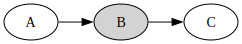

In [23]:
#| label: graph-chain
import graphviz

graphviz.Source('''
    digraph "Chain" {
        rankdir=LR;
        B [style=filled];
        A -> B -> C;
    }
''')

### Fork (diverging connection)

:::{prf:definition} Fork (diverging connection)
![](#graph-fork)

- If $B$ is observed, $A$ and $C$ become **independent**: $A \perp C \mid B = b$
- If $B$ is _not_ observed, $A$ and $C$ are generally **dependent** (share a common cause $B$).

The absence of a link between $A$ and $C$ implies that these two are **independent** if $B$ is observed.
:::

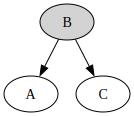

In [26]:
#| label: graph-fork
import graphviz

graphviz.Source('''
    digraph "Fork" {
        B [style=filled];
        B -> A;
        B -> C;
    }
''')

### Collider (converging connection)

:::{prf:definition} Collider (converging connection)
![](#graph-collider)

- If $B$ is observed (or on any descendant of $B$), $A$ and $C$ become **dependent**.
- If $B$ is _not_ observed: $A$ and $C$ are **independent**.

This is the phenomenon of **explaining away**: If $B$ is observed, then learning that $A$ happened makes $C$ less likely, and vice versa, because they are competing explanations for $B$.

This behaviour is the opposite of chains and forks, where conditioning on the middle node **blocks** dependence; in a collider, conditioning on the middle node **creates** dependence.
:::

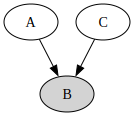

In [27]:
#| label: graph-collider
import graphviz

graphviz.Source('''
    digraph "Collider" {
        B [style=filled];
        A -> B;
        C -> B;
    }
''')

## d-Separation (directional separation)

Think of paths as **pipes** and statistical dependence as **water**:

- If at least one path is open, dependence can flow.
- If **all** paths are blocked, then $A$ and $C$ are conditionally independent given $Z$.

:::{prf:definition} d-Separation
A path $p$ is blocked by a _conditioning_ set of nodes $Z$ if and only if:

1. $p$ contains a **chain** $A \rightarrow B \rightarrow C$ or **fork** $A \leftarrow B \rightarrow C$ such that $B \in Z$
2. $p$ contains a **collider** $A \rightarrow B \leftarrow C$ such that $B \notin Z$ and no descendant of $B$ is in $Z$.

If all paths between $A$ and $C$ are blocked by $Z$, then $A$ and $C$ are **d-separated given** $Z$:

$$
A \perp C \mid Z
$$
:::

## Testing Conditional Independence in Data

Given a candidate causal DAG $G$ that could have generated a dataset $D$:

1. Use d-Separation to list all implied conditional independencies (e.g. $X \perp Z \mid Y$).
2. For each implied independence, test on data:
   - Use regression or other statistical tools,
   - Check whether the conditional dependence **is approximately zero**.

**For example for the following graph $G$:**

![](#graph-testing-conditional-independence)

- Suppose $G$ implies $W \perp Z_1 \mid X$.
- Regress $W$ on $X$ and $Z_1$ using $w = \beta_X x + \beta_{Z_1} z_1$
- If $\beta_{Z_1} \approx 0$ (statistically insignificant), this is consistent with the model.
- If $\beta_{Z_1}$ is clearly non-zero, the independence fails in data, so $G$ **must be rejected**.

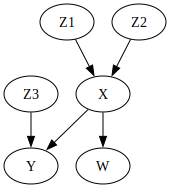

In [10]:
#| label: graph-testing-conditional-independence
import graphviz

graphviz.Source('''
    digraph "Testing Conditional Independence" {
        Z1 -> X;
        Z2 -> X;
        Z3 -> Y;
        X -> W;
        X -> Y;
    }
''')

## Markov equivalence and equivalence classes

Many different DAGs can induce the **same set of conditional independencies**. These DAGs are **Markov equivalent**.

:::{prf:definition} Equivalence Class of Causal Graphs
Two DAGs $G_1$ and $G_2$ are Markov equivalent and are in the same equivalence class if:

- They have the same **skeleton** (same undirected edges), and
- They have the same **v-structures**:
  - Nodes $A \to C \leftarrow B$ where $A$ and $B$ are not directly connected.
:::

:::{attention}
All graphs in a Markov equivalence class:

- Imply the same **d-separation** statements
- Have the same **testable implications** for observational data.

Thus:

> With observational data alone, we can often identify only the **equivalence class** of causal graphs, not the unique DAG.

Additional assumptions (e.g. temporal order) or **interventions** are needed to fully orient the graph.
:::

### Factorization examples

Consider three variables $X,Y,Z$ where we know that

$$
X \perp Y \mid Z.
$$

Several factorizations of $P(X,Y,Z)$ are consistent with this:

- One possible factorization:
  :::{figure} #graph-factorization-1
  $$
  P(x,y,z) = P(y \mid x,z)\,P(z \mid x)\,P(x)
  $$
  :::

  If $P(y \mid x,z)$ does **not** depend on $x$, we can write this as
  :::{figure} #graph-factorization-2
  $$
  P(x,y,z) = P(y \mid z)\,P(z \mid x)\,P(x).
  $$
  :::

- Another factorization:
  :::{figure} #graph-factorization-3
  $$
  P(x,y,z) = P(x \mid y,z)\,P(y \mid z)\,P(z)
           = P(x \mid z)\,P(y \mid z)\,P(z).
  $$
  :::

Different DAGs correspond to different factorization orders, but if they encode the same conditional independencies
($X \perp Y \mid Z$), they belong to the same **Markov equivalence class**.

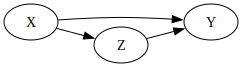

In [3]:
#| label: graph-factorization-1
import graphviz

graphviz.Source('''
    digraph "Factorization 1" {
        rankdir=LR;
        X -> Y;
        Z -> Y;
        X -> Z;
    }
''')

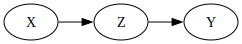

In [4]:
#| label: graph-factorization-2
import graphviz

graphviz.Source('''
    digraph "Factorization 2" {
        rankdir=LR;
        Z -> Y;
        X -> Z;
    }
''')

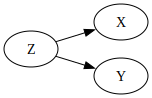

In [31]:
#| label: graph-factorization-3
import graphviz

graphviz.Source('''
    digraph "Factorization 3" {
        rankdir=LR;
        Z -> X;
        Z -> Y;
    }
''')

## Parameter sharing

In many models, multiple nodes share the **same** local conditional distribution. This is called **parameter sharing**.

:::{important} Parameter sharing
- Reduces the **number of parameters** (reduces complexity of the model)
- Increases **data per parameter** (improves reliability)
- Reduces **expressiveness** (cannot encode arbitrary differences between positions or variables)
:::

Consider a chain of four binary variables:

:::{figure} #graph-factorization-4
$X \to Y \to Z \to W$
:::

**Estimating the full joint distribution**

- Full joint distribution $P(X,Y,Z,W)$ has $2^4 = 16$ entries (15 degrees of freedom)
- With limited data, many combinations $(x,y,z,w)$ are rare or absent
- Frequency estimates for these cells are unreliable

**Using factorization**

$$
P(X,Y,Z,W)
= p(X)\,p(Y \mid X)\,p(Z \mid Y)\,p(W \mid Z)
$$

- Each factor involves at most 2 variables
- We estimate each conditional with more data per parameter
- This yields **more stable** estimates from the same dataset

$\implies$ Exploiting the graph structure dramatically reduces the number of parameters and improves estimation in high dimensions.

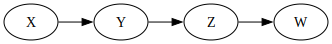

In [12]:
#| label: graph-factorization-4
import graphviz

graphviz.Source('''
    digraph "Factorization 4" {
        rankdir = LR;
        X -> Y;
        Y -> Z
        Z -> W;
    }
''')

### Hidden Markov Model (HMM)

:::{figure} #graph-hmm

- Hidden states $H_1,\dots,H_n$
- Observations $E_1,\dots,E_n$
:::

$$
P(H,E)
= p_{\text{start}}(h_1)
  \prod_{i=2}^n p_{\text{trans}}(h_i \mid h_{i-1})
  \prod_{i=1}^n p_{\text{emit}}(e_i \mid h_i).
$$

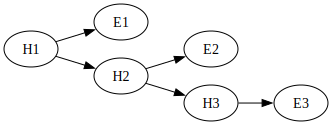

In [9]:
#| label: graph-hmm
import graphviz

graphviz.Source('''
    digraph "Factorization 3" {
        rankdir=LR;
        H1 -> E1;
        H1 -> H2;
        H2 -> E2;
        H2 -> H3;
        H3 -> E3;
    }
''')

## Probabilistic Inference

Input:

- A Bayesian network $P(X_1,\dots,X_n)$,
- Evidence $E=e$ for some variables $E \subseteq X$,
- Query variables $Q \subseteq X$,

Output:

$$
P(Q \mid E=e) \quad \leftrightarrow \quad  P(Q = q \mid E = e) \quad \text{for all values q}
$$

The output is a table that specifies a probability for each assignment of values to Q.

:::{prf:definition} Inference (Conceptually)
1. Write the joint probability as a product of local conditional probabilities:
   $$
   P(X_1,\dots,X_n) = \prod_i p(x_i \mid x_{\text{Parents}(i)}).
   $$
2. Sum out non-query, non-evidence variables.
3. Normalize to obtain probabilities.
:::

:::{attention} Inference (in practice)
- Exact inference is **intractable** in general (NP-hard),
- **inference assumes parameters are known**, and then ask:
  > Where do all these local conditional probabilities come from?

Therefore, we need to **learn** these parameters from data.
:::


### Parameter learning with fully observed data

Assume:

- The BN structure (graph) is known,
- Training data $D_{\text{train}}$ consists of **full assignments** to all variables $X_1,\dots,X_n$,
- We want to estimate parameters $\vartheta$ (local conditional probabilities).

The **maximum likelihood** objective is

$$
\max_{\vartheta}
\prod_{x \in D_{\text{train}}} P(x; \vartheta)
= \max_{\vartheta}
\prod_{x \in D_{\text{train}}}
  \prod_{i=1}^n p_\vartheta\big(x_i \mid x_{\text{Parents}(i)}\big).
$$

Taking logs converts the product into a sum, and the problem **decouples** across variables and parent configurations.

For each node $X_i$ and parent assignment $x_{\text{Parents}(i)}$, we solve:

$$
\max_{p(\cdot \mid x_{\text{Parents}(i)})}
\sum_{x_i} N(x_i, x_{\text{Parents}(i)}) \log p(x_i \mid x_{\text{Parents}(i)})
$$

subject to $\sum_{x_i} p(x_i \mid x_{\text{Parents}(i)}) = 1$.

Solution:

:::{prf:theorem} Maximum likelihood via count-and-normalize
$$
\hat{p}(x_i \mid x_{\text{Parents}(i)})
= \frac{N(x_i, x_{\text{Parents}(i)})}
       {\sum_{x_i'} N(x_i', x_{\text{Parents}(i)})},
$$
:::

### Maximum likelihood via count-and-normalize

:::{prf:algorithm} Maximum likelihood via count-and-normalize

1. **Counting step**  
   For every training example $x$ and each variable $X_i$:
   - Extract $x_i$ and $x_{\text{Parents}(i)}$,
   - Increment $\text{count}_i(x_{\text{Parents}(i)}, x_i)$.

2. **Normalization step**  
   For each variable $X_i$ and each parent configuration $x_{\text{Parents}(i)}$:
   $$
   \hat{p}(x_i \mid x_{\text{Parents}(i)})
   = \frac{\text{count}_i(x_{\text{Parents}(i)}, x_i)}
           {\sum_{x_i'} \text{count}_i(x_{\text{Parents}(i)}, x_i')}.
   $$

This amounts to performing ML **locally** on each conditional distribution, rather than on the full joint distribution.
:::

### Using pgmpy for MLE

Suppose we have the following data:

In [20]:
!pip install pgmpy pygraphviz graphviz

import pandas as pd
import graphviz

In [21]:
data = pd.DataFrame(data={'fruit': ["banana", "apple", "banana", "apple", "banana","apple", "banana",
                                    "apple", "apple", "apple", "banana", "banana", "apple", "banana",],
                          'tasty': ["yes", "no", "yes", "yes", "yes", "yes", "yes",
                                    "yes", "yes", "yes", "yes", "no", "no", "no"],
                          'size': ["large", "large", "large", "small", "large", "large", "large",
                                    "small", "large", "large", "large", "large", "small", "small"]})
data.head()

,fruit,tasty,size
0,banana,yes,large
1,apple,no,large
2,banana,yes,large
3,apple,yes,small
4,banana,yes,large


We know that the variables relate as follows:

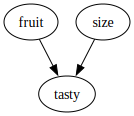

In [22]:
from pgmpy.models import DiscreteBayesianNetwork

model = DiscreteBayesianNetwork([('fruit', 'tasty'), ('size', 'tasty')])  # fruit -> tasty <- size
graphviz.Source(model.to_graphviz().string())

Parameter learning is the task to estimate the values of the conditional probability distributions (CPDs), for the variables `fruit`, `size`, and `tasty`.

#### State counts
To make sense of the given data, we can start by counting how often each state of the variable occurs. If the variable is dependent on parents, the counts are done conditionally on the parents states, i.e. separately for each parent configuration:

In [23]:
from pgmpy.estimators import ParameterEstimator
pe = ParameterEstimator(model, data)
print("\n", pe.state_counts('fruit'))  # unconditional
print("\n", pe.state_counts('tasty'))  # conditional on fruit and size

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'fruit': 'C', 'tasty': 'C', 'size': 'C'}



         count
fruit        
apple       7
banana      7

 fruit apple       banana      
size  large small  large small
tasty                         
no      1.0   1.0    1.0   1.0
yes     3.0   2.0    5.0   0.0


We can see, for example, that as many apples as bananas were observed and that `5` large bananas were tasty, while only `1` was not.

#### Maximum Likelihood Estimation

A natural estimate for the CPDs is to simply use the *relative frequencies*, with which the variable states have occured. We observed `7 apples` among a total of `14 fruits`, so we might guess that about `50%` of `fruits` are `apples`.

This approach is *Maximum Likelihood Estimation (MLE)*. According to MLE, we should fill the CPDs in such a way, that $P(\text{data}|\text{model})$ is maximal. This is achieved when using the *relative frequencies*. `pgmpy` supports MLE as follows:

In [24]:
from pgmpy.estimators import MaximumLikelihoodEstimator
mle = MaximumLikelihoodEstimator(model, data)
print(mle.estimate_cpd('fruit'))  # unconditional
print(mle.estimate_cpd('tasty'))  # conditional

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'fruit': 'C', 'tasty': 'C', 'size': 'C'}


+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+------------+--------------+-----+---------------+
| fruit      | fruit(apple) | ... | fruit(banana) |
+------------+--------------+-----+---------------+
| size       | size(large)  | ... | size(small)   |
+------------+--------------+-----+---------------+
| tasty(no)  | 0.25         | ... | 1.0           |
+------------+--------------+-----+---------------+
| tasty(yes) | 0.75         | ... | 0.0           |
+------------+--------------+-----+---------------+


- `mle.estimate_cpd(variable)` computes the state counts and divides each cell by the (conditional) sample size.
- The `mle.get_parameters()`-method returns a list of CPDs for all variables of the model.

- The built-in `fit()`-method of `BayesianNetwork` provides more convenient access to parameter estimators:


In [25]:
# Calibrate all CPDs of `model` using MLE:
model.fit(data, estimator=MaximumLikelihoodEstimator)

print(model.get_cpds('fruit'))
print(model.get_cpds('tasty'))

# Or alternatively, if you want to get all CPDs at once:
# for cpd in model.get_cpds():
#     print(cpd)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'fruit': 'C', 'tasty': 'C', 'size': 'C'}


+---------------+-----+
| fruit(apple)  | 0.5 |
+---------------+-----+
| fruit(banana) | 0.5 |
+---------------+-----+
+------------+--------------+-----+---------------+
| fruit      | fruit(apple) | ... | fruit(banana) |
+------------+--------------+-----+---------------+
| size       | size(large)  | ... | size(small)   |
+------------+--------------+-----+---------------+
| tasty(no)  | 0.25         | ... | 1.0           |
+------------+--------------+-----+---------------+
| tasty(yes) | 0.75         | ... | 0.0           |
+------------+--------------+-----+---------------+


While very straightforward, the ML estimator has the problem of *overfitting* to the data. In above CPD, the probability of a large banana being tasty is estimated at `0.833`, because `5` out of `6` observed large bananas were tasty. Fine. But note that the probability of a small banana being tasty is estimated at `0.0`, because we observed only one small banana and it happened to be not tasty. But that should hardly make us certain that small bananas aren't tasty!

We simply do not have enough observations to rely on the observed frequencies. If the observed data is not representative for the underlying distribution, ML estimations will be extremly far off.

:::{attention} Lack of Data
When estimating parameters for Bayesian networks, **lack of data is a frequent problem**. Even if the total sample size is very large, the fact that state counts are done conditionally for each parents configuration causes immense fragmentation. If a variable has 3 parents that can each take 10 states, then state counts will be done separately for `10^3 = 1000` parents configurations.

This makes **MLE very fragile and unstable for learning Bayesian Network parameters**. A way to mitigate MLE's overfitting is **Bayesian Parameter Estimation**.
:::

## Laplace smoothing and Dirichlet priors

Pure maximum likelihood can assign **zero probability** to unseen events:

- If some $(x_i,x_{\text{Parents}(i)})$ combination never appears in training data, then
  $$
  \hat{p}(x_i \mid x_{\text{Parents}(i)}) = 0.
  $$

To avoid this, we use **Laplace smoothing**:

- Add $\lambda > 0$ to each count before normalization.

For discrete $X_i$:

$$
\hat{p}(x_i \mid x_{\text{Parents}(i)})
= \frac{\lambda + N(x_i, x_{\text{Parents}(i)})}
       {\sum_{x_i'} \big(\lambda + N(x_i', x_{\text{Parents}(i)})\big)}.
$$

**Interpretation**

- Equivalent to a **Dirichlet prior** on the conditional distribution and doing **MAP** estimation.
- Larger $\lambda$ produces stronger smoothing (probabilities closer to uniform).
- As we collect more data, the posterior concentrates around the empirical frequencies.


### Smoothing in Python

The Bayesian Parameter Estimator starts with already existing prior CPDs, that express our beliefs about the variables *before* the data was observed. Those "priors" are then updated, using the state counts from the observed data.

One can think of the priors as consisting in *pseudo state counts*, that are added to the actual counts before normalization.
Unless one wants to encode specific beliefs about the distributions of the variables, one commonly chooses uniform priors, i.e. ones that deem all states equiprobable.

A very simple prior is the so-called `K2` prior (_Laplace smoothing_), which simply adds `1` to the count of every single state.
A somewhat more sensible choice of prior is `BDeu` (Bayesian Dirichlet equivalent uniform prior). For `BDeu` we need to specify an _equivalent sample size_ `N` and then the pseudo-counts are the equivalent of having observed `N` uniform samples of each variable (and each parent configuration):

In [26]:
from pgmpy.estimators import BayesianEstimator
est = BayesianEstimator(model, data)

print(est.estimate_cpd('tasty', prior_type='BDeu', equivalent_sample_size=10))

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'fruit': 'C', 'tasty': 'C', 'size': 'C'}


+------------+---------------------+-----+---------------------+
| fruit      | fruit(apple)        | ... | fruit(banana)       |
+------------+---------------------+-----+---------------------+
| size       | size(large)         | ... | size(small)         |
+------------+---------------------+-----+---------------------+
| tasty(no)  | 0.34615384615384615 | ... | 0.6428571428571429  |
+------------+---------------------+-----+---------------------+
| tasty(yes) | 0.6538461538461539  | ... | 0.35714285714285715 |
+------------+---------------------+-----+---------------------+


The estimated values in the CPDs are now more conservative. In particular, the estimate for a small banana being not tasty is now around `0.64` rather than `1.0`. Setting `equivalent_sample_size` to `10` means that for each parent configuration, we add the equivalent of 10 uniform samples (here: `+5` small bananas that are tasty and `+5` that aren't).

`BayesianEstimator`, too, can be used via the `fit()`-method:

In [29]:
import numpy as np
import pandas as pd
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator

# generate data
data = pd.DataFrame(np.random.randint(low=0, high=2, size=(5000, 4)), columns=['A', 'B', 'C', 'D'])
model = DiscreteBayesianNetwork([('A', 'B'), ('A', 'C'), ('D', 'C'), ('B', 'D')])

model.fit(data, estimator=BayesianEstimator, prior_type="BDeu") # default equivalent_sample_size=5
for cpd in model.get_cpds():
    print(cpd)
    break

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'A': 'N', 'B': 'N', 'C': 'N', 'D': 'N'}


+------+----------+
| A(0) | 0.497003 |
+------+----------+
| A(1) | 0.502997 |
+------+----------+


## Learning with hidden or missing variables

In many applications, some variables are **unobserved** in the training data.

Example:

- In a movie-rating model with variables $(G,R_1,R_2)$, the genre $G$ might be hidden:
  - Observed: ratings $(R_1,R_2)$,
  - Hidden: $G$.

We then aim to maximize the **marginal likelihood** over observed variables:

$$
\max_{\vartheta}
\prod_{e \in D_{\text{train}}} p(E=e; \vartheta),
$$

where

$$
p(E=e; \vartheta) = \sum_h P(H=h, E=e; \vartheta)
$$

sums over hidden variables $H$.

Direct optimization is hard because:

- The sum over $h$ is inside the product over examples,
- There is no simple closed-form solution like in the fully observed case.

This motivates the **EM algorithm**.

## Expectation–Maximization (EM) algorithm

:::{prf:definition} Expectation-Maximization (EM)
$$
\max_{\vartheta}
\prod_{e \in D_{\text{train}}}
\sum_h P(H=h, E=e; \vartheta).
$$

- Hidden variables $H$
- Observed variables $E$
- Parameters $\vartheta$
:::

EM solves maximum marginal likelihood by iteratively constructing **pseudo-complete** datasets. It comes with the following guarantees:

- The marginal log-likelihood **does not decrease** at each iteration
- Converges to a **local optimum** (not necessarily global)

:::{prf:algorithm} Expectation-Maximization (EM)
- initialize $\vartheta$ randomly
- repeat until convergence:
  - **E-step:**
    - For each hidden variable $h$, compute:
      $$
      q(h) = P(H=h \mid E=e; \vartheta).
      $$
    - Create fully-observed weighted examples of each pair $(h,e)$ with weight $q(h)$
  - **M-step:**
    - Perform maximum likelihood (count and normalize) on weighted examples
    - Update $\vartheta$
:::

### EM in Python

For this example, we simulate some data from the [alarm model](https://www.bnlearn.com/bnrepository/discrete-medium.html#alarm) and use it to learn back the model parameters. In this example, we simply use the structure to the _alarm model_.

In [13]:
from pgmpy.utils import get_example_model
from pgmpy.models import DiscreteBayesianNetwork

# Load the alarm model and simulate data from it.
alarm_model = get_example_model(model="alarm")
samples = alarm_model.simulate(n_samples=int(1e3))

print(samples.head())

# Define a new model with the same structure as the alarm model.
new_model = DiscreteBayesianNetwork(ebunch=alarm_model.edges())

/Users/marbetschar/Development/marbetschar/notes/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating for node: BP: 100%|██████████| 37/37 [00:00<00:00, 843.29it/s]

  ERRCAUTER  ARTCO2 VENTALV VENTLUNG  SAO2 PULMEMBOLUS      BP HYPOVOLEMIA  \
0      TRUE     LOW    HIGH      LOW  HIGH       FALSE    HIGH       FALSE   
1     FALSE  NORMAL  NORMAL     ZERO   LOW       FALSE     LOW       FALSE   
2     FALSE    HIGH    ZERO     ZERO   LOW       FALSE     LOW        TRUE   
3     FALSE    HIGH    ZERO     ZERO   LOW       FALSE  NORMAL        TRUE   
4     FALSE    HIGH    ZERO     ZERO   LOW       FALSE     LOW       FALSE   

      CVP  HRBP  ...     TPR  MINVOL INTUBATION PVSAT MINVOLSET      CO HREKG  \
0  NORMAL  HIGH  ...  NORMAL    HIGH     NORMAL  HIGH    NORMAL    HIGH   LOW   
1  NORMAL  HIGH  ...     LOW  NORMAL   ONESIDED   LOW    NORMAL    HIGH  HIGH   
2    HIGH  HIGH  ...     LOW    ZERO     NORMAL   LOW    NORMAL  NORMAL  HIGH   
3    HIGH  HIGH  ...  NORMAL    ZERO     NORMAL   LOW    NORMAL  NORMAL  HIGH   
4     LOW  HIGH  ...     LOW    ZERO     NORMAL   LOW    NORMAL    HIGH  HIGH   

  LVEDVOLUME    FIO2 STROKEVOLUME  
0     NO

The _Expectation Maximization_ (EM) estimator can work in the case when latent variables are present in the model. To simulate this scenario, we will specify some of the variables in our `new_model` as latents and drop those variables from samples to simulate missing data.

In [14]:
model_latent = DiscreteBayesianNetwork(alarm_model.edges(), latents={'HISTORY', 'CVP'})
samples_latent = samples.drop(['HISTORY', 'CVP'], axis=1)

In [18]:
from pgmpy.estimators import ExpectationMaximization as EM

# Initialize the EM estimator
em_est = EM(model=model_latent, data=samples_latent)

# Iterate through CPDs generated by the model
for cpd in em_est.get_parameters():
    print(f"Conditional Probability Distribution for {cpd.variable}:")
    print(cpd)
    break

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'ERRCAUTER': 'C', 'ARTCO2': 'C', 'VENTALV': 'C', 'VENTLUNG': 'C', 'SAO2': 'C', 'PULMEMBOLUS': 'C', 'BP': 'C', 'HYPOVOLEMIA': 'C', 'HRBP': 'C', 'PRESS': 'C', 'VENTMACH': 'C', 'VENTTUBE': 'C', 'EXPCO2': 'C', 'HRSAT': 'C', 'LVFAILURE': 'C', 'DISCONNECT': 'C', 'PAP': 'C', 'PCWP': 'C', 'KINKEDTUBE': 'C', 'ANAPHYLAXIS': 'C', 'INSUFFANESTH': 'C', 'HR': 'C', 'ERRLOWOUTPUT': 'C', 'CATECHOL': 'C', 'SHUNT': 'C', 'TPR': 'C', 'MINVOL': 'C', 'INTUBATION': 'C', 'PVSAT': 'C', 'MINVOLSET': 'C', 'CO': 'C', 'HREKG': 'C', 'LVEDVOLUME': 'C', 'FIO2': 'C', 'STROKEVOLUME': 'C'}
  0%|          | 0/100 [00:01<?, ?it/s]

Conditional Probability Distribution for ERRCAUTER:
+------------------+-------+
| ERRCAUTER(FALSE) | 0.887 |
+------------------+-------+
| ERRCAUTER(TRUE)  | 0.113 |
+------------------+-------+


## Markov networks and factor graphs

A **Markov network** (also called a Markov random field) is an undirected graphical model that represents a joint
distribution over $X = (X_1,\dots,X_n)$ via **factors**.

We define:

- A set of factors $f_1,\dots,f_m$, each depending on a subset of variables.
- For any assignment $x$, a **weight**
  $$
  \text{Weight}(x) = \prod_{j=1}^m f_j(x).
  $$

The normalized joint distribution is

$$
P(X=x) = \frac{\text{Weight}(x)}{Z},
\qquad
Z = \sum_{x'} \text{Weight}(x')
$$

where $Z$ is the **partition function**.

A **factor graph** is a bipartite graph with:

- Variable nodes $X_i$,
- Factor nodes $f_j$,
- Edges connecting factors to the variables they depend on.

Factor graphs generalize Bayesian networks and are convenient for describing models like object tracking, image models,
and general constraint systems.

## Object tracking: MAP trajectory vs marginal probabilities

In the object tracking example:

- $X_1,X_2,X_3$ are discrete positions,
- Observation factors $o_i(x_i)$ reflect sensor likelihoods,
- Transition factors $t_i(x_i,x_{i+1})$ enforce smooth motion.

The factor graph defines the weight

$$
\text{Weight}(x_1,x_2,x_3)
= o_1(x_1)\,o_2(x_2)\,o_3(x_3)\,t_1(x_1,x_2)\,t_2(x_2,x_3).
$$

Two different tasks:

1. **MAP assignment** (most likely trajectory):
   $$
   (x_1^{*},x_2^{*},x_3^{*}) = \arg\max_{x_1,x_2,x_3} \text{Weight}(x_1,x_2,x_3).
   $$

2. **Marginal probabilities**:
   $$
   P(X_2 = v)
   = \sum_{x_1,x_3} P(X_1=x_1,X_2=v,X_3=x_3)
   = \frac{1}{Z} \sum_{x_1,x_3} \text{Weight}(x_1,v,x_3).
   $$

Lesson:

- The most probable **trajectory** may place the object at one position at time 2,
- While the **marginal** $P(X_2=v)$ may be higher for another position when summing over all trajectories.

Thus, returning only the MAP trajectory does not convey **uncertainty** about individual positions.

## Gibbs sampling for approximate marginals

Computing exact marginals

$$
P(X_i = v) = \sum_{x : x_i = v} P(X = x)
$$

is often infeasible in large models. **Gibbs sampling** approximates these marginals via a Markov chain.

Algorithm (high level):

1. Initialize a complete assignment $x^{(0)}$.

2. For $t = 0,1,2,\dots$:
   - Choose a variable index $i$,
   - Sample a new value for $X_i$ from the conditional
     $$
     X_i^{(t+1)} \sim P\big(X_i \mid X_{-i} = x_{-i}^{(t)}\big),
     $$
     where $X_{-i}$ denotes all variables except $X_i$.

3. After a **burn-in** period, collect samples $x^{(t)}$ and estimate marginals by frequencies:
   $$
   \hat{P}(X_i = v)
   = \frac{\#\{t: X_i^{(t)} = v\}}{\text{number of collected samples}}.
   $$

Key properties:

- Gibbs sampling is a form of **Markov Chain Monte Carlo (MCMC)**.
- Under mild conditions (irreducibility, aperiodicity), the chain converges to the true joint distribution.
- It only needs **local** computations (looking at factors involving $X_i$), making it scalable to large models.

The slides illustrate Gibbs sampling on the object tracking / Markov network example.